# Protein interactions

# Setup and Info

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from rna_motif_library.util import (
    get_nucleotide_atom_type,
)
from rna_motif_library.dataframe_tools import parse_motif_indentifier

from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
    draw_box_around_subplot,
    draw_boxes_around_coords_list,
    merge_neighboring_coords,
)

PLOT_PATH = "../figures/plots"

In [2]:
def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["mtype"] = df["mtype"].map(type_mapping)
    return df

In [3]:
df = pd.read_json(
    "../data/summaries/protein_interactions/non_redundant_protein_hbonds.json"
)
df["res_type_1"] = df["res_1"].str.split("-").str[1]
df["res_type_2"] = df["res_2"].str.split("-").str[1]
df["atom_type_1"] = df["atom_1"].apply(get_nucleotide_atom_type)

In [4]:
df_motifs = pd.read_json(
    "../data/summaries/protein_interactions/non_redundant_motif_protein_interactions.json"
)
df_motifs = rename_motif_types(df_motifs)

In [5]:
df_gini = pd.read_csv("../rna_protein_hbonds_normalized_gini.csv")

In [6]:
df_motifs.iloc[0]

motif_id                                             SSTRAND-1-A-7NHA-2
hbonds                [[D-A-10-, O2P, B-ARG-365-, NH1, 0.94200000000...
num_hbonds                                                            3
num_protein_chains                                                    2
num_rna_res                                                           1
num_protein_res                                                       3
mtype                                                     Single Strand
msize                                                                 1
msequence                                                             A
pdb_id                                                             7NHA
Name: 0, dtype: object

# Plots

# Residue Level Analysis

## plot amino acid hbond count

<BarContainer object of 20 artists>

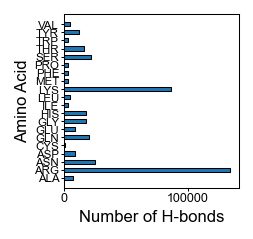

In [7]:
def plot_amino_acid_hbond_counts(ax, df):
    """
    Create a horizontal bar plot of H-bond counts by amino acid, sorted by amino acid name.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to plot on.
        df (pd.DataFrame): DataFrame containing at least the 'res_type_2' column.
    """
    counts = df["res_type_2"].value_counts()
    # Reindex to sort by amino acid name (alphabetically)
    counts = counts.reindex(sorted(counts.index))
    tbars = ax.barh(
        counts.index, counts.values, edgecolor="black", linewidth=0.5, height=0.5
    )
    ax.set_ylabel("Amino Acid", labelpad=2)
    ax.set_xlabel("Number of H-bonds", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=5.5, xtick_size=6)
    return tbars


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
plot_amino_acid_hbond_counts(ax, df)

## plot amino acid count by atom type

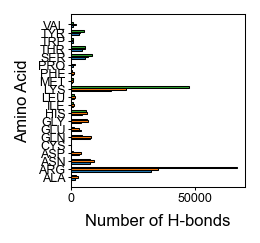

In [8]:
def plot_amino_acid_hbond_by_atomtype(df, ax):
    """
    Create a grouped horizontal bar plot of H-bond counts by amino acid and atom type.

    Parameters:
        df (pd.DataFrame): DataFrame containing at least 'atom_type_1' and 'res_type_2' columns.
        ax (matplotlib.axes.Axes): The axis to plot on.
    """

    # Get all unique amino acids present in any of the three interaction types
    amino_acids = sorted(
        set(
            df[df["atom_type_1"].isin(["base", "sugar", "phos"])]["res_type_2"].unique()
        )
    )

    # Count for each interaction type
    base_counts = df[df["atom_type_1"] == "base"]["res_type_2"].value_counts()
    sugar_counts = df[df["atom_type_1"] == "sugar"]["res_type_2"].value_counts()
    phos_counts = df[df["atom_type_1"] == "phos"]["res_type_2"].value_counts()

    # Ensure all amino acids are present in each count (fill missing with 0)
    base_vals = np.array([base_counts.get(aa, 0) for aa in amino_acids])
    sugar_vals = np.array([sugar_counts.get(aa, 0) for aa in amino_acids])
    phos_vals = np.array([phos_counts.get(aa, 0) for aa in amino_acids])

    bar_height = 0.6
    bar_width = bar_height / 3

    y = np.arange(len(amino_acids))

    bars_base = ax.barh(
        y - bar_width,
        base_vals,
        height=bar_width,
        label="Base",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    bars_sugar = ax.barh(
        y,
        sugar_vals,
        height=bar_width,
        label="Sugar",
        color="#ff7f0e",
        edgecolor="black",
        linewidth=0.5,
    )
    bars_phos = ax.barh(
        y + bar_width,
        phos_vals,
        height=bar_width,
        label="Phosphate",
        color="#2ca02c",
        edgecolor="black",
        linewidth=0.5,
    )

    ax.set_yticks(y)
    ax.set_yticklabels(amino_acids)
    ax.set_ylabel("Amino Acid")
    ax.set_xlabel("Number of H-bonds")
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Example usage:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
plot_amino_acid_hbond_by_atomtype(df, ax)

## plot nucleotide count by atom type

<Axes: xlabel='Number of H-bonds', ylabel='Nucleotide'>

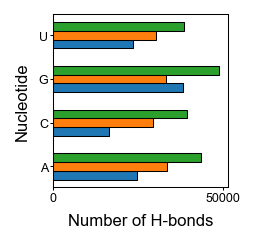

In [9]:
def plot_nucleotide_hbond_by_atomtype(df, ax=None):
    """
    Create a grouped bar plot of nucleotide H-bond counts broken down by atom type.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing columns 'atom_type_1' and 'res_type_1'.
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.

    Returns
    -------
    matplotlib.axes.Axes
        The axes with the plot.
    """
    import numpy as np

    atom_types = ["base", "sugar", "phos"]
    nucleotides = sorted(
        set(df[df["atom_type_1"].isin(atom_types)]["res_type_1"].unique())
    )

    base_counts = df[df["atom_type_1"] == "base"]["res_type_1"].value_counts()
    sugar_counts = df[df["atom_type_1"] == "sugar"]["res_type_1"].value_counts()
    phos_counts = df[df["atom_type_1"] == "phos"]["res_type_1"].value_counts()

    base_vals = np.array([base_counts.get(nt, 0) for nt in nucleotides])
    sugar_vals = np.array([sugar_counts.get(nt, 0) for nt in nucleotides])
    phos_vals = np.array([phos_counts.get(nt, 0) for nt in nucleotides])

    bar_height = 0.6
    bar_width = bar_height / 3

    if ax is None:
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
    else:
        fig = ax.figure

    y = np.arange(len(nucleotides))

    bars_base = ax.barh(
        y - bar_width,
        base_vals,
        height=bar_width,
        label="Base",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    bars_sugar = ax.barh(
        y,
        sugar_vals,
        height=bar_width,
        label="Sugar",
        color="#ff7f0e",
        edgecolor="black",
        linewidth=0.5,
    )
    bars_phos = ax.barh(
        y + bar_width,
        phos_vals,
        height=bar_width,
        label="Phosphate",
        color="#2ca02c",
        edgecolor="black",
        linewidth=0.5,
    )

    ax.set_yticks(y)
    ax.set_yticklabels(nucleotides)
    ax.set_ylabel("Nucleotide")
    ax.set_xlabel("Number of H-bonds")
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
plot_nucleotide_hbond_by_atomtype(df, ax)

## gini index summaries 

In [10]:
df_gini.tail(10)

,res_1,res_2,atom_1,atom_2,num_datapoints,normalized_gini,mean_score,mean_dihedral_angle,mean_angle_1
727,C,THR,N4,OG1,108,0.038162,0.691306,9.770370,126.575926
728,C,GLU,N4,OE1,179,0.035575,0.677056,-3.192737,124.413966
729,A,GLN,O3',NE2,110,0.031149,0.703591,20.513636,122.738182
730,A,HIS,N3,NE2,149,0.030512,0.658711,-8.693960,94.571141
731,C,THR,O3',OG1,104,0.023222,0.705067,-3.040385,127.189423
732,A,GLU,O1P,OE2,142,0.023201,0.695915,7.180282,128.435915
733,U,LYS,N3,NZ,244,0.018068,0.647578,-0.832787,109.470492
734,C,ARG,N1,NH1,109,-0.001009,0.600817,-12.962385,84.713761
735,U,THR,O2,OG1,190,-0.013553,0.722595,11.049474,131.418947
736,U,GLU,N3,OE2,112,-0.013586,0.743991,19.373214,107.902679


In [11]:
df_gini.iloc[0]

res_1                           A
res_2                         ALA
atom_1                        O4'
atom_2                          N
num_datapoints                180
normalized_gini          0.765964
mean_score               0.588106
mean_dihedral_angle     73.133889
mean_angle_1           117.386111
Name: 0, dtype: object

In [12]:
df_gini.iloc[-2]

res_1                           U
res_2                         THR
atom_1                         O2
atom_2                        OG1
num_datapoints                190
normalized_gini         -0.013553
mean_score               0.722595
mean_dihedral_angle     11.049474
mean_angle_1           131.418947
Name: 735, dtype: object

In [13]:
df_gini.sort_values(by="mean_score", ascending=False).head(10)

,res_1,res_2,atom_1,atom_2,num_datapoints,normalized_gini,mean_score,mean_dihedral_angle,mean_angle_1
27,A,TRP,O1P,N,107,0.528859,0.816991,44.471028,133.499065
385,U,TRP,O1P,NE1,159,0.284618,0.798931,-7.619497,127.220126
384,A,ILE,O2P,N,104,0.284910,0.797817,43.308654,133.134615
13,C,HIS,O2',ND1,530,0.586672,0.795804,0.630189,125.789434
209,U,TYR,O4,N,121,0.363730,0.793256,-22.191736,131.896694
356,A,TRP,O1P,NE1,174,0.296641,0.792943,38.714943,132.409770
271,G,GLU,N1,OE2,251,0.330907,0.790367,16.958566,110.604382
104,G,HIS,N2,O,178,0.420778,0.788551,66.094944,120.948876
22,G,ARG,O6,NE,789,0.542102,0.788399,11.952598,126.483397
2,C,ARG,O2P,N,568,0.675912,0.785463,50.882746,125.872007


Text(0, 0.5, 'Count')

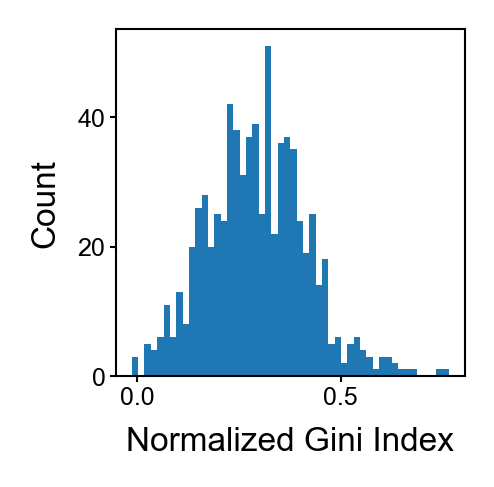

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax.hist(df_gini["normalized_gini"], bins=50)
publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
ax.set_xlabel("Normalized Gini Index")
ax.set_ylabel("Count")

## plot angle_1 vs dihedral_angle for high gini index

In [15]:
def get_sub_df(df, res_1, res_2, atom_1, atom_2):
    return df.query(
        "res_type_1 == @res_1 and res_type_2 == @res_2 and atom_1 == @atom_1 and atom_2 == @atom_2"
    )

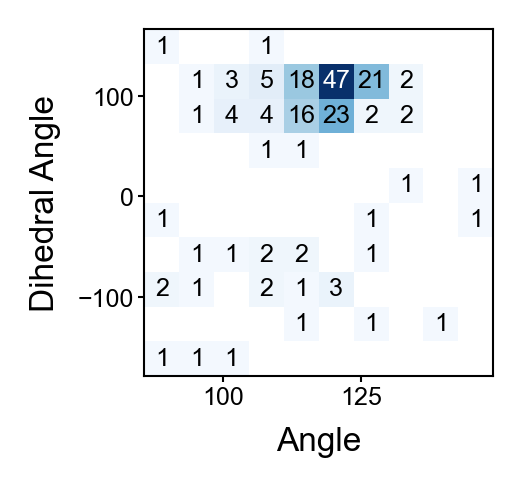

In [16]:
def plot_angle_dihedral_hist2d_high_gini_index(df, ax):
    """
    Plots a 2D histogram of angle_1 vs dihedral_angle for a specific subset of df,
    and annotates bins with counts greater than 2. Boxes with count 0 are colored white.

    Parameters:
    - df: pandas DataFrame
    - ax: matplotlib Axes object
    """

    df_sub = get_sub_df(df, "A", "ALA", "O4'", "N")
    hist = ax.hist2d(df_sub["angle_1"], df_sub["dihedral_angle"], bins=10, cmap="Blues")
    ax.set_xlabel("Angle")
    ax.set_ylabel("Dihedral Angle")

    # Add numbers on each box if greater than 2, and white box if count == 0
    counts = hist[0]
    xedges = hist[1]
    yedges = hist[2]
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            count = int(counts[i, j])
            x0 = xedges[i]
            x1 = xedges[i + 1]
            y0 = yedges[j]
            y1 = yedges[j + 1]
            x = (x0 + x1) / 2
            y = (y0 + y1) / 2
            if count == 0:
                # Draw a white rectangle over the bin
                rect = patches.Rectangle(
                    (x0, y0),
                    x1 - x0,
                    y1 - y0,
                    linewidth=0,
                    edgecolor=None,
                    facecolor="white",
                    zorder=2,
                )
                ax.add_patch(rect)
            elif count > 0:
                color = "black" if count < 40 else "white"
                ax.text(
                    x,
                    y,
                    str(count),
                    color=color,
                    ha="center",
                    va="center",
                    fontsize=6,
                    zorder=3,
                )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
plot_angle_dihedral_hist2d_high_gini_index(df, ax)

## plot angle dihedral hist2d for low gini index

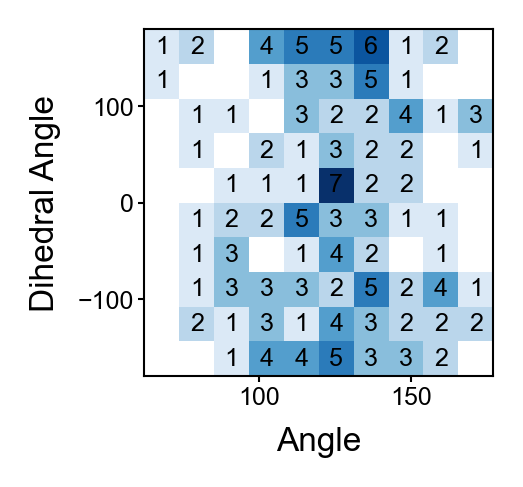

In [17]:
def plot_angle_dihedral_hist2d_low_gini_index(df, ax):
    """
    Plots a 2D histogram of angle_1 vs dihedral_angle for a specific subset of df,
    and annotates bins with counts greater than 2.

    Parameters:
    - df: pandas DataFrame
    - ax: matplotlib Axes object
    """
    df_sub = get_sub_df(df, "C", "GLU", "N4", "OE1")
    hist = ax.hist2d(df_sub["angle_1"], df_sub["dihedral_angle"], bins=10, cmap="Blues")
    ax.set_xlabel("Angle")
    ax.set_ylabel("Dihedral Angle")

    # Add numbers on each box if greater than 2
    counts = hist[0]
    xedges = hist[1]
    yedges = hist[2]
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            count = int(counts[i, j])
            x0 = xedges[i]
            x1 = xedges[i + 1]
            y0 = yedges[j]
            y1 = yedges[j + 1]
            x = (x0 + x1) / 2
            y = (y0 + y1) / 2
            if count == 0:
                # Draw a white rectangle over the bin
                rect = patches.Rectangle(
                    (x0, y0),
                    x1 - x0,
                    y1 - y0,
                    linewidth=0,
                    edgecolor=None,
                    facecolor="white",
                    zorder=2,
                )
                ax.add_patch(rect)
            if count > 0:
                x = (xedges[i] + xedges[i + 1]) / 2
                y = (yedges[j] + yedges[j + 1]) / 2
                ax.text(
                    x,
                    y,
                    str(count),
                    color="black",
                    ha="center",
                    va="center",
                    fontsize=6,
                )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
plot_angle_dihedral_hist2d_low_gini_index(df, ax)

# Motif Level Analysis

In [18]:
# Define colors for each motif type
colors = {
    "Helix": "gray",
    "N-way": "red",
    "Two-way": "orange",
    "Hairpin": "blue",
    "Single\nStrand": "green",
}

## Number of H-bonds per motif type

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_13060/793012074.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] * len(mtype_totals.index), rotation=0)


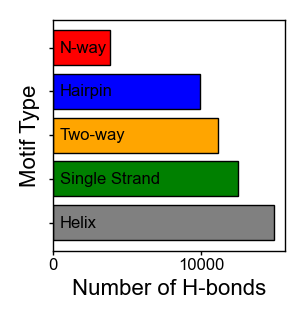

In [64]:
# Define colors for each motif type
colors = {
    "Helix": "gray",
    "N-way": "red",
    "Two-way": "orange",
    "Hairpin": "blue",
    "Single Strand": "green",
}


def plot_hbond_counts_per_motif_type(df, ax):
    # Calculate total H-bonds per motif type
    mtype_totals = df["mtype"].value_counts()
    # Plot bars with same colors as previous plot
    bars = ax.barh(
        mtype_totals.index,
        mtype_totals.values,
        color=[colors[mtype] for mtype in mtype_totals.index],
        edgecolor="black",
        linewidth=0.5,
    )

    # Add motif type labels inside the bars
    for i, (motif_type, value) in enumerate(
        zip(mtype_totals.index, mtype_totals.values)
    ):
        ax.text(
            500,  # place just a little out from the axis to the right
            i,  # y position
            motif_type,
            va="center",
            ha="left",
            color="black",
            fontsize=6,
            fontfamily="Arial",
        )

    # Remove y-axis label and y-tick labels since they're now in the bars
    ax.set_ylabel("Motif Type", labelpad=2)
    ax.set_xlabel("Number of H-bonds", labelpad=2)
    ax.set_yticklabels([""] * len(mtype_totals.index), rotation=0)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=200)
plot_hbond_counts_per_motif_type(df_motifs, ax)

## Number of H-bonds per motif

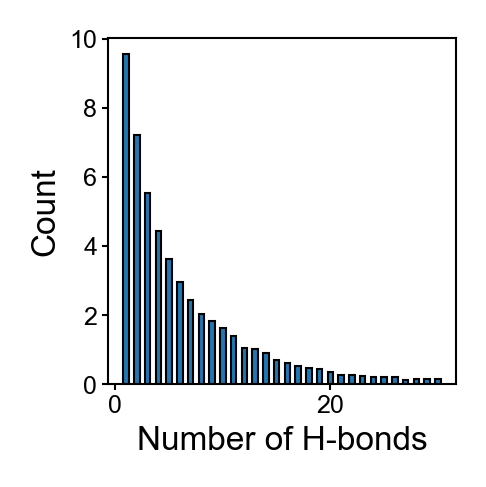

In [20]:
def plot_hbond_histogram_per_motif(df, ax):
    """
    Plots a histogram of the number of H-bonds per motif.

    Parameters:
    df (pd.DataFrame): DataFrame containing a column 'hbonds' with lists of H-bonds per motif.
    ax (matplotlib.axes.Axes): The axes on which to plot.
    """
    num_hbonds_per_motif = df["hbonds"].apply(len)
    num_hbonds_per_motif = num_hbonds_per_motif[num_hbonds_per_motif <= 30]

    # Count occurrences of each number of H-bonds per motif
    counts = num_hbonds_per_motif.value_counts().sort_index()
    ax.bar(
        counts.index,
        counts.values,
        edgecolor="black",
        linewidth=0.5,
        width=0.5,
    )
    ax.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
    ax.set_yticklabels(["0", "2", "4", "6", "8", "10"])
    ax.set_xlabel("Number of H-bonds", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
plot_hbond_histogram_per_motif(df_motifs, ax)

## Number of protein chains per motif

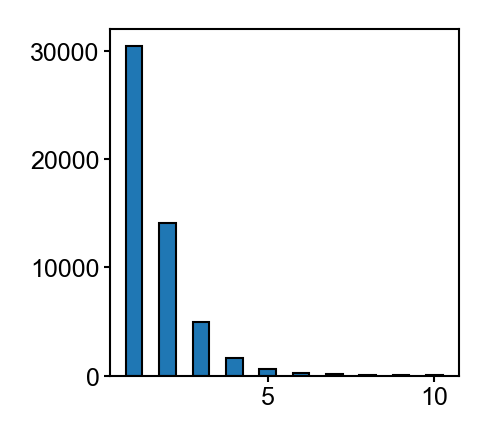

In [21]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
protein_chain_counts = df_motifs["num_protein_chains"].value_counts()
protein_chain_counts = protein_chain_counts[protein_chain_counts.index <= 10]
ax.bar(
    protein_chain_counts.index,
    protein_chain_counts.values,
    edgecolor="black",
    linewidth=0.5,
    width=0.5,
)
publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

In [22]:
data = []
for i, g in df_motifs.groupby("pdb_id"):
    chains_data = {}
    for j, row in g.iterrows():
        for hb in row["hbonds"]:
            spl = hb[2].split("-")
            print(spl)
            break
        break

['H', 'TYR', '53', '']
['A', 'SER', '269', '']
['A', 'ARG', '667', '']
['M', 'TYR', '35', '']
['M', 'ARG', '102', '']
['M', 'TYR', '35', '']
['M', 'ARG', '102', '']
['K', 'ARG', '238', '']
['O', 'HIS', '132', '']
['L', 'GLY', '65', '']
['M', 'TYR', '35', '']
['M', 'ARG', '102', '']
['M', 'ARG', '102', '']
['M', 'ARG', '102', '']
['K', 'ARG', '238', '']
['BH', 'GLY', '99', '']
['A', 'SER', '288', '']
['42', 'ARG', '25', '']
['C', 'GLN', '1062', '']
['C', 'GLN', '1062', '']
['B', 'LYS', '50', '']
['A', 'MET', '335', '']
['A', 'THR', '424', '']
['A', 'LYS', '41', '']
['P', 'ARG', '330', '']
['A', 'GLU', '46', '']
['A', 'ARG', '287', '']
['2', 'SER', '3126', '']
['A', 'ARG', '28', '']
['U', 'ARG', '58', '']
['E', 'SER', '86', '']
['A', 'ASN', '58', '']
['C', 'GLU', '140', '']
['B', 'HIS', '9', '']
['P', 'ARG', '21', '']
['A', 'LYS', '163', '']
['A', 'ILE', '100', '']
['C', 'ARG', '26', '']
['A', 'GLN', '88', '']
['B', 'ASP', '30', '']
['A', 'GLU', '220', '']
['A', 'GLU', '323', '']
['A', '

In [23]:
hbonds = []
for i, row in df_motifs.iterrows():
    for hb in row["hbonds"]:
        spl = hb[2].split("-")
        hbonds.append([row["mtype"], spl[1]])
df_hbonds = pd.DataFrame(hbonds, columns=["mtype", "aa"])

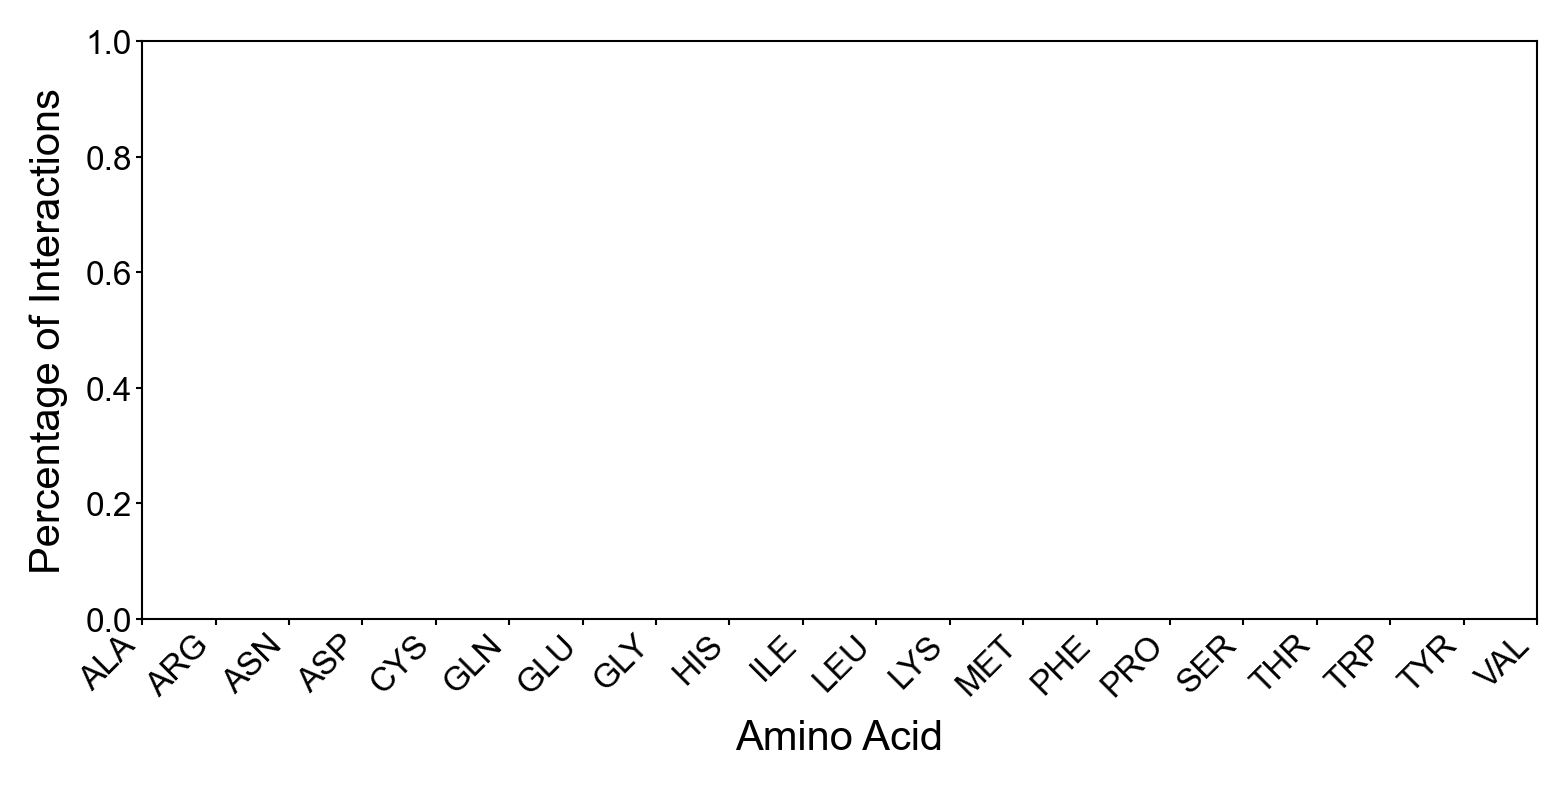

In [25]:
# Calculate percentage of interactions for each mtype and amino acid
df_pct = df_hbonds.groupby(["mtype", "aa"]).size().unstack(fill_value=0)
df_pct = df_pct.div(df_pct.sum(axis=1), axis=0) * 100

# Get unique mtypes for colors
mtypes = df_pct.index.unique()

# Create the plot
fig, ax = plt.subplots(figsize=(6.0, 2.5), dpi=300)

# Plot a line for each mtype
mtypes = []
for mtype in mtypes:
    ax.plot(
        df_pct.columns,
        df_pct.loc[mtype],
        label=mtype,
        marker="o",
        alpha=0.7,
        color=colors[mtype],
    )

ax.set_xticks(range(len(df_pct.columns)))
ax.set_xticklabels(df_pct.columns, rotation=45, ha="right")
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Percentage of Interactions")
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
publication_style_ax(ax)

In [26]:
def get_sub_df(df, res_1, res_2, atom_1, atom_2):
    return df.query(
        "res_type_1 == @res_1 and res_type_2 == @res_2 and atom_1 == @atom_1 and atom_2 == @atom_2"
    )

# Final Figure

In [27]:
def draw_boxes_around_coords_list(fig, coords_list):
    """
    Draw a box around each set of subplot coordinates in coords_list,
    using a different color for each box.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        The figure to draw the boxes on.
    coords_list : list of tuple
        List of (left, bottom, width, height) tuples in figure coordinates.
    """
    color_cycle = (
        plt.rcParams["axes.prop_cycle"]
        .by_key()
        .get(
            "color",
            [
                "red",
                "blue",
                "green",
                "orange",
                "purple",
                "brown",
                "pink",
                "gray",
                "olive",
                "cyan",
            ],
        )
    )

    for i, coords in enumerate(coords_list):
        color = color_cycle[i % len(color_cycle)]
        draw_box_around_subplot(
            fig, coords, linewidth=2, edgecolor=color, facecolor="none"
        )

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_13060/793012074.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] * len(mtype_totals.index), rotation=0)


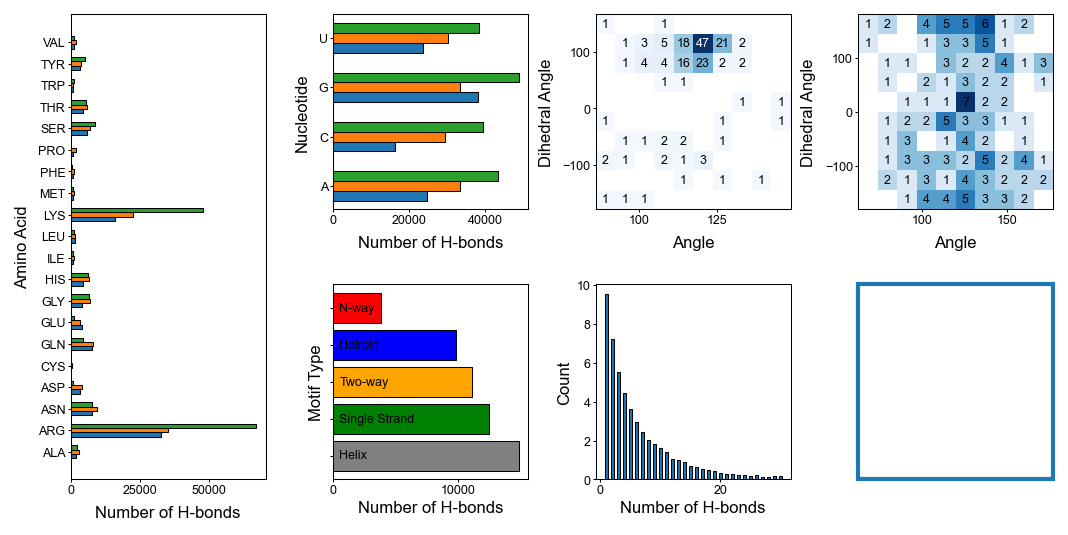

In [65]:
fig_size = (7, 6)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
coords_list = merge_neighboring_coords(coords_list, [0, 4])
fig = plt.figure(figsize=fig_size, dpi=150)
fig.patches = []

ax1 = fig.add_axes(coords_list[0])
plot_amino_acid_hbond_by_atomtype(df, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_nucleotide_hbond_by_atomtype(df, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_angle_dihedral_hist2d_high_gini_index(df, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_angle_dihedral_hist2d_low_gini_index(df, ax4)

ax5 = fig.add_axes(coords_list[4])
plot_hbond_counts_per_motif_type(df_motifs, ax5)

ax6 = fig.add_axes(coords_list[5])
plot_hbond_histogram_per_motif(df_motifs, ax6)

draw_boxes_around_coords_list(fig, coords_list[6:])


fig.savefig(os.path.join(PLOT_PATH, "Figure_3.png"), dpi=600)